In [11]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

pd.options.display.max_columns = 4000
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 4000

In [12]:
datafile = r"/Users/kathleenszabo/Documents/Cornell Tech/Product Studio/b2bDataAnalysisDataset.xlsx"
data = pd.read_excel(datafile)

In [13]:
# Same sales person between referring company and listed company

for i in range(len(data)):
    if pd.isnull(data.iloc[i,4]):
        data.loc[i,'Same salesperson as referring company'] = "Not applicable"
    else:
        if data.iloc[i,4][:7] == "Company":                
            x = np.argwhere(data['Account Name'] == data.iloc[i,4])
            if len(x) == 0:
                data.loc[i,'Same salesperson as referring company'] = False
            else:
                assigned_salespeople = data.iloc[x[0],:]
                assigned_salespeople = assigned_salespeople['Opportunity Assigned to Full Name']
                if data.iloc[i, 2] in assigned_salespeople.item():
                    data.loc[i,'Same salesperson as referring company'] = True
                else:
                    data.loc[i,'Same salesperson as referring company'] = False
        else:
            data.loc[i,'Same salesperson as referring company'] = "Not applicable"

In [14]:
# Add in total sales column
data['Total Sales'] = (12 * data['Monthly Revenue']) + data['Fixed Revenue'] + data['Yearly Revenue']

In [15]:
# Update sales status

def find_status(x):
    if x['Sales Stage'] == "Live":
        if pd.isnull(x['Disqualified Date']):
            return "Live"
        else:
            return "Discontinued sales"
    else:
        if pd.isnull(x['Disqualified Date']):
            return "Current Prospect"
        else:
            return "Lost Prospect"

data['Status'] = data.apply(lambda x: find_status(x), axis=1)

In [16]:
# Scatter plot comparing total sales to business area

opportunity_codes = {"eCommerce Business": 1, "POS Acquiring": 2, "Payment Terminal Business": 3}
data['Opportunity Business Area Coded'] = data['Opportunity Business Area'].replace(opportunity_codes)

In [17]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


data_drop_current_prospects = data[data['Status'] != "Current Prospect"]

# Code success variables
success_codes = {"Live": 2, "Discontinued sales": 2, "Lost Prospect": 1, "Current Prospect": 0}
data_drop_current_prospects['Success'] = data_drop_current_prospects['Status'].replace(success_codes)

# Fill N/As
values_for_na = {'Opportunity Business Area Coded': 1, 'Gender coded': 3}
data_drop_current_prospects = data_drop_current_prospects.fillna(value = values_for_na)

data_drop_current_prospects = data_drop_current_prospects[data_drop_current_prospects['Opportunity Assigned to Full Name'] != "Unassigned Unassigned"]

dummies = pd.get_dummies(data_drop_current_prospects['Opportunity Assigned to Full Name'])
dummies_columns = dummies.columns

data_drop_current_prospects = pd.concat([data_drop_current_prospects, dummies], axis=1)

dummies_vertical = pd.get_dummies(data_drop_current_prospects['Opportunity Business Area Coded'])
dummies_vertical_cols = dummies_vertical.columns
data_drop_current_prospects = pd.concat([data_drop_current_prospects, dummies_vertical], axis=1)

# Code same sales person as referral
sales_person_referal_dict = {True: 1, False: 0, "Not applicable": -1}
data_drop_current_prospects['Sales Person Referral Coded'] = data_drop_current_prospects['Same salesperson as referring company'].replace(sales_person_referal_dict)

# Code opportunity sales process
sales_process_dict = {"New Business": 1, "Upsell": 0}
data_drop_current_prospects['Sales Process Coded'] = data_drop_current_prospects['Opportunity Sales Process'].replace(sales_process_dict)

# Code whether it was a referral in general
data_drop_current_prospects['Referral'] = 1.0 * (data_drop_current_prospects['Sales Person Referral Coded'] > -1)

# X variable columns
columns = ['Referral', 'Sales Process Coded']

for column in dummies_vertical_cols:
    columns.append(column)
for column in dummies_columns:
    columns.append(column)

# Predictive variables: gender, vertical, Same salesperson as referring company, total sales, opportunity sales process
X = data_drop_current_prospects.loc[:,columns].as_matrix()
y = data_drop_current_prospects['Success'].as_matrix()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [30]:
# New columns for printing data to csv

columns_updated_sp_names = ['Referral', 'Sales Process Coded']

dummies_vertical_cols = ["eCommerce Business", "POS Acquiring", "Payment Terminal Business"]
for column in dummies_vertical_cols:
    columns_updated_sp_names.append("Opportunity Business Area "+column)
np.random.seed(0)
salesperson_ids = []
for i in range(len(dummies_columns)):
    random_int = np.random.randint(10000,99999)
    columns_updated_sp_names.append("Salesperson "+str(random_int)+str(i%10))
    salesperson_ids.append("Salesperson "+str(random_int)+str(i%10))

columns_for_export = columns_updated_sp_names
columns_for_export.append("Success")
data_for_export = pd.concat([data_drop_current_prospects.loc[:,columns],data_drop_current_prospects['Success']], axis=1)
data_for_export.columns = columns_for_export
data_for_export.to_csv('Data_to_read_in.csv')

# pd.DataFrame(X_train, columns=columns_updated_sp_names).to_csv('X_train_b2b.csv')


# pd.DataFrame(X_train, columns=columns_updated_sp_names).to_csv('X_train_b2b.csv')
# pd.DataFrame(X_test, columns=columns_updated_sp_names).to_csv('X_test_b2b.csv')
# pd.DataFrame(y_train, columns=['Success']).to_csv('y_train_b2b.csv')
# pd.DataFrame(y_test, columns=['Success']).to_csv('y_test_b2b.csv')

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)

log_reg = LogisticRegression().fit(X_train,y_train)
print("Score of the model: "+str(log_reg.score(X_test, y_test)))

Score of the model: 0.852287581699


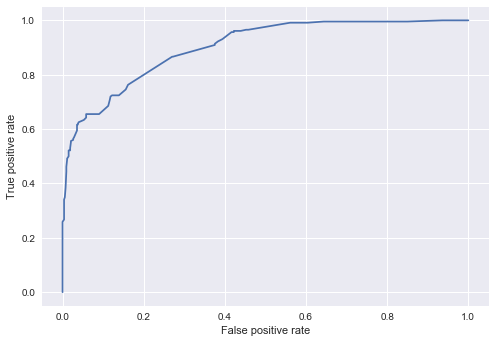

AUC: 0.902095328977


In [92]:
# TEST THE MODEL

from sklearn.metrics import roc_curve
y_score = log_reg.predict_proba(X_test)[:,1]
y_test_boolean = (y_test == 2)

#Define a method calculating the false positive rate and the true positive rate to make the ROC curve
def calculate_false_true_pos_rate(cutoff, y_score):
    
    false_positive = 0
    true_positive = 0
    false_negative = 0
    true_negative = 0
    
    # Creates an array filled with True or False depending on whether the distance is less than our cutoff or not
    positive_negative = (y_score > cutoff)
    
    # True positives are those where the distance is less than the cutoff and it's actually a match
    num_true_positives = np.sum(np.logical_and(positive_negative, y_test_boolean))
    # Actual positives are any where it's actually a match
    num_actual_positives = np.sum(y_test_boolean)
    true_positive_rate = num_true_positives / num_actual_positives
    
    # False positives are those wehre the distance is less than the cutoff but it's not actually a match
    num_false_positives = np.sum(np.logical_and(positive_negative, np.logical_not(y_test_boolean)))
    # Actual negatives are any where it's not a match
    num_actual_negatives = np.sum(np.logical_not(y_test_boolean))
    false_positive_rate = num_false_positives / num_actual_negatives
    
    return false_positive_rate, true_positive_rate

pairs = []
for i in range(0,100):
    false_positive_rate, true_positive_rate = calculate_false_true_pos_rate(i/100.0, y_score)
    pairs.append([false_positive_rate, true_positive_rate])
    
pairs_np = np.asarray(pairs)
plt.plot(pairs_np[:,0], pairs_np[:,1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig(r"/Users/kathleenszabo/Documents/Cornell Tech/Product Studio/pc043-mastercard/ROC curve.png")
plt.show()
plt.close()

# Test the model: ROC SCORE
from sklearn.metrics import roc_auc_score
print("AUC: " + str(roc_auc_score(y_test_boolean.astype(int), y_score)))

In [93]:
# Create database of salesperson information - average success rate and ID

table = pd.pivot_table(data_drop_current_prospects, values=['ID'], index=['Opportunity Assigned to Full Name'], columns=['Success'], aggfunc=len, margins=True)
table2 = table.div( table.iloc[:,-1], axis=0 )
table2_df = pd.DataFrame(table2.to_records())

salesperson_data = pd.concat([table2_df.iloc[:,2], pd.DataFrame(salesperson_ids)], axis = 1)
salesperson_data.columns = ['Overall success rate', 'Salesperson ID']

# Export salesperson data
salesperson_data.to_csv("Salesperson_avg_success_rate.csv")

In [94]:
# TEST IF WE ALWAYS GET AT LEAST ONE GREEN

import copy

X_test_sales_person = copy.deepcopy(X_test)

skip_columns = 5

count_no_green = 0
for lead in range(len(X_test_sales_person)):

    for i in range(50):
        X_test_sales_person[lead,skip_columns+i] = 0

    X_test_sales_person_row = X_test_sales_person[lead,:].reshape(1,-1) 
    
    green = False
    
    for i in range(50):
        
        # Replace which sales person is being plugged in
        X_test_sales_person_row[0][skip_columns+i] = 1

        # Predict the probability of a sale under this salesperson
        prob = log_reg.predict_proba(X_test_sales_person_row)[0][1]
        if prob > 0.7:
            green = True
        
        # Reset salesperson marker to 0
        X_test_sales_person_row[0][skip_columns+i] = 0
    
    if green:
        result = " can have a 70% chance of success."
    
    else:
        result = " cannot have a 70% chance of success."
        count_no_green += 1
print(count_no_green)

0


In [95]:
# TEST LEADS INDIVIDUALLY

lead = 90

for i in range(50):
    X_test_sales_person[lead,skip_columns+i] = 0
    
X_test_sales_person_row = X_test_sales_person[lead,:].reshape(1,-1) 
    
for i in range(50):
    X_test_sales_person_row[0][skip_columns+i] = 1

    prob = log_reg.predict_proba(X_test_sales_person_row)[0][1]
    color = "Red"
    if prob > 0.7:
        color = "Green"
    elif prob > 0.5:
        color = "Yellow"
    if color == "Green":
        print("\nSalesperson: "+salesperson_ids[i])
    X_test_sales_person_row[0][skip_columns+i] = 0


Salesperson: Salesperson 535671

Salesperson: Salesperson 962936

Salesperson: Salesperson 904718

Salesperson: Salesperson 626202

Salesperson: Salesperson 901863

Salesperson: Salesperson 270894

Salesperson: Salesperson 806082

Salesperson: Salesperson 107972

Salesperson: Salesperson 538903


In [96]:
# TEST LEADS INDIVIDUALLY - compare overall success rate vs predicted for specific lead

lead = 15

for i in range(50):
    X_test_sales_person[lead,skip_columns+i] = 0
    
X_test_sales_person_row = X_test_sales_person[lead,:].reshape(1,-1) 
    
for i in range(50):
    X_test_sales_person_row[0][skip_columns+i] = 1

    prob = log_reg.predict_proba(X_test_sales_person_row)[0][1]
    if prob > salesperson_data.loc[i, 'Overall success rate']:
        print("\n"+salesperson_data.loc[i, 'Salesperson ID'])
        print("Overall success rate: "+str(salesperson_data.loc[i, 'Overall success rate']))
        print("Predicted success rate for this lead: "+str(prob))
    
    X_test_sales_person_row[0][skip_columns+i] = 0


Salesperson 782680
Overall success rate: 0.1125
Predicted success rate for this lead: 0.38253693493

Salesperson 526132
Overall success rate: 0.0208333333333
Predicted success rate for this lead: 0.132820960979

Salesperson 312434
Overall success rate: 0.307692307692
Predicted success rate for this lead: 0.538240419244

Salesperson 519935
Overall success rate: 0.1875
Predicted success rate for this lead: 0.325752582554

Salesperson 904718
Overall success rate: 0.807692307692
Predicted success rate for this lead: 0.902824665146

Salesperson 909669
Overall success rate: 0.0603448275862
Predicted success rate for this lead: 0.231705975403

Salesperson 495121
Overall success rate: 0.113636363636
Predicted success rate for this lead: 0.26092063444

Salesperson 289836
Overall success rate: 0.444444444444
Predicted success rate for this lead: 0.544146610576

Salesperson 996887
Overall success rate: 0.180616740088
Predicted success rate for this lead: 0.406022937044

Salesperson 169219
Overal